# このファイルについて
- about: トラカンデータと検索データのマージ
- author: 松永
- ref: ../cudf/1_1_traffic_merge_all.ipynb

In [1]:
import numpy as np
import pandas as pd
import cudf
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
import cupy
cupy.cuda.Device(3).use()

<CUDA Device 3>

In [32]:
# 道路名
# TARGET_ROAD = 'kannetsu'
TARGET_ROAD = 'touhoku'

PERIOD = '20231001-20240331'

# 交通量
TRAFFIC_DIR = f'./traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_{PERIOD}_2KP.csv'

# 検索量 csv
SEARCH_COUNT_DIR = f'./search_count'
SPECIFIED_SEARCH_COUNT_CSV = f'{SEARCH_COUNT_DIR}/search-count_specified_{PERIOD}.csv'
UNSPECIFIED_SEARCH_COUNT_CSV = f'{SEARCH_COUNT_DIR}/search-count_unspecified_{PERIOD}.csv'

In [33]:
df_traffic = cudf.from_pandas(
    pd.read_csv(
        TRAFFIC_CSV, parse_dates=True, index_col='datetime', 
        dtype={'start_code': str, 'end_code': str,}
    )
).reset_index()

print(df_traffic.shape)
df_traffic.head(3)

(7800192, 29)


,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed
0,2023-10-01,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.93470,139.723697,...,3,5.7,5.47,4.8,10.5,down,100.0,2.0,60.0,90.0
1,2023-10-01,岩槻,浦和本線,1040016,1040013,11,11,35.93470,35.89012,139.690750,...,3,5.7,5.60,10.5,4.8,up,100.0,2.0,54.0,86.0
2,2023-10-01,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.93470,139.723697,...,1,5.7,7.30,4.8,10.5,down,100.0,3.0,20.0,87.0


# 検索データをマージ

## 時間指定あり

In [34]:
df_specified = cudf.from_pandas(
    pd.read_csv(SPECIFIED_SEARCH_COUNT_CSV, parse_dates=True, index_col='passing_time', 
                dtype={'start_code': str, 'end_code': str})
).reset_index()

print(df_specified.shape)
df_specified.head(3)

(4211266, 4)


,passing_time,start_code,end_code,search
0,2023-10-01 00:00:00,1040013,1040016,24
1,2023-10-01 00:05:00,1040013,1040016,2
2,2023-10-01 00:10:00,1040013,1040016,1


In [35]:
df_specified.tail(3)

,passing_time,start_code,end_code,search
4211263,2024-03-31 23:45:00,1800106,1800111,0
4211264,2024-03-31 23:50:00,1800106,1800111,0
4211265,2024-03-31 23:55:00,1800106,1800111,0


In [36]:
df_traffic = df_traffic.merge(
    df_specified, how='left', 
    left_on=['datetime', 'start_code', 'end_code'], right_on=['passing_time', 'start_code', 'end_code']
)
df_traffic.drop('passing_time', axis=1, inplace=True)
df_traffic.shape

(7800192, 30)

In [37]:
# 2021/4/2以降で欠損埋め
cond = (df_traffic.datetime >= pd.Timestamp('2021/4/2')) & df_traffic.search.isna()

df_traffic.loc[cond, 'search'] = 0

In [38]:
# %time msno.matrix(df_traffic.to_pandas(), labels=True)
# plt.show()

## 時間指定なし

In [39]:
df_unspecified = cudf.from_pandas(
    pd.read_csv(UNSPECIFIED_SEARCH_COUNT_CSV, dtype={'start_code': str, 'end_code': str})
)

print(df_unspecified.shape)
df_unspecified.head(3)

(14640, 4)


,search_date,start_code,end_code,search
0,2023-10-01,1040013,1040016,9381.0
1,2023-10-01,1040016,1040013,8807.0
2,2023-10-01,1040016,1040020,9988.0


In [40]:
df_unspecified.tail(3)

,search_date,start_code,end_code,search
14637,2024-03-31,1800096,1800106,3200.0
14638,2024-03-31,1800106,1800096,2148.0
14639,2024-03-31,1800106,1800111,3148.0


In [41]:
# 日付を表すカラムを追加
df_traffic = df_traffic.assign(date=df_traffic.datetime.to_pandas().map(lambda dt: dt.date()))
# 日付でマージ
df_traffic = df_traffic.merge(
    df_unspecified, how='left', 
    left_on=['date', 'start_code', 'end_code'], right_on=['search_date', 'start_code', 'end_code'],
    suffixes=('_specified', '_unspecified')
).drop(['date', 'search_date'], axis=1)

In [42]:
# 2021/4/2以降で欠損埋め
cond = (
    (df_traffic.datetime >= pd.Timestamp('2021/4/2'))
    & df_traffic.search_unspecified.isna()
)
df_traffic.loc[cond, 'search_unspecified'] = 0

In [14]:
# %time msno.matrix(df_traffic.to_pandas(), labels=True)
# plt.show()

# ~欠損値を確認~

### 長期間にわたって線形補間できない欠損が存在することを確認

In [19]:
ROADS = [
    'kannetsu',
    'touhoku'
]
PERIODS = [
    # '20210401-20220331',
    # '20220401-20230331',
    # '20230401-20230930',
    '20231001-20240131'
]

In [17]:
def col_interpolate(df: cudf.DataFrame, cols: list, method='linear'):
    """
    dfのcol列内の欠損を区間ごとに線形補間する
    """
    grouped_intp = lambda g: g.reset_index(drop=True).loc[:, cols].interpolate(method=method, axis=0)
    
    df = df.sort_values(['start_code', 'end_code', 'KP', 'datetime']).reset_index(drop=True)
    interpolated = (df.to_pandas()
                    .groupby(['start_code', 'end_code', 'KP'])
                    .apply(grouped_intp)
                    .sort_index()
                    .reset_index())
    
    df_res = df.assign(**{col: interpolated[col] for col in cols})
    return df_res

In [20]:
for road in ROADS:
    for period in PERIODS:
        print('='*30, road, period, '='*30)

        df_traffic = cudf.from_pandas(
            pd.read_csv(
                f'{TRAFFIC_DIR}/{road}_{period}_2KP.csv', parse_dates=True, index_col='datetime', 
                dtype={'start_code': str, 'end_code': str,}
            )
        ).reset_index()

        df_traffic2 = col_interpolate(df_traffic, cols=['speed', 'OCC', 'allCars'], method='linear')

        # 線形補間ができなかった箇所を列挙
        for g_name, df_g in df_traffic2.loc[df_traffic2.speed.isna()].to_pandas().groupby(['start_name', 'end_name', 'KP']):
            print('-'*20, g_name, '-'*20)
            print('# of null:', df_g.shape[0])
            print('Period:', f'{df_g.datetime.iloc[0]} --> {df_g.datetime.iloc[-1]}')
            print()

        del df_traffic, df_traffic2

============================== kannetsu 20231001-20240131 ==============================
-------------------- ('坂戸西スマート', '東松山', 34.97) --------------------
# of null: 35424
Period: 2023-10-01 00:00:00 --> 2024-01-31 23:55:00

-------------------- ('寄居ＰＡ', '本庄児玉', 64.91) --------------------
# of null: 23520
Period: 2023-10-01 00:00:00 --> 2023-12-21 15:55:00

-------------------- ('東松山', '坂戸西スマート', 35.68) --------------------
# of null: 35424
Period: 2023-10-01 00:00:00 --> 2024-01-31 23:55:00

-------------------- ('渋川伊香保', '駒寄ＰＡ', 102.53) --------------------
# of null: 35424
Period: 2023-10-01 00:00:00 --> 2024-01-31 23:55:00

============================== touhoku 20231001-20240131 ==============================
-------------------- ('加須', '羽生', 34.256) --------------------
# of null: 34692
Period: 2023-10-01 00:00:00 --> 2024-01-29 10:55:00

-------------------- ('宇都宮', '鹿沼', 100.261) --------------------
# of null: 35424
Period: 2023-10-01 00:00:00 --> 2024-01-31 23:55:00

-----

### 速度の欠損パターンを確認する

In [21]:
road = 'kannetsu'
# road = 'touhoku'

period = '20231001-20240131'

In [22]:
df_traffic = pd.read_csv(f'{TRAFFIC_DIR}/{road}_{period}_2KP.csv', dtype={'start_code': str, 'end_code': str,})
df_traffic.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed
0,2023-10-01 00:00:00,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.80615,35.75582,139.535511,...,3,8.6,2.26,9.4,0.8,up,100.0,2.0,54.0,82.0
1,2023-10-01 00:00:00,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,...,3,8.6,2.48,0.8,9.4,down,100.0,2.0,71.0,97.0
2,2023-10-01 00:00:00,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,...,3,8.6,3.90,0.8,9.4,down,100.0,2.0,64.0,86.0


In [23]:
def create_na_table(df: pd.DataFrame):
    na_table = df.isna().sum()
    na_percent_table = (df.isna().sum() / len(df_traffic)) * 100
    
    na_table = (pd.concat([na_table, na_percent_table], axis=1)
                .rename(columns={0: '# of null', 1: '% of null'})
                .pipe(lambda _df: _df.loc[_df['# of null'] > 0])
                .sort_values('% of null'))
    return na_table

In [24]:
create_na_table(df_traffic)

,# of null,% of null
OCC,255048,5.217293
allCars,255048,5.217293
speed,260794,5.334834


In [25]:
cond1 = df_traffic.speed.isna() & df_traffic.OCC.isna()
cond2 = df_traffic.speed.isna() & df_traffic.OCC.notna()
cond3 = df_traffic.speed.isna() & df_traffic.allCars.notna()

df_tmp1 = df_traffic.loc[cond1]
print(len(df_tmp1))
df_tmp2 = df_traffic.loc[cond2]
print(len(df_tmp2))
df_tmp3 = df_traffic.loc[cond3]
print(len(df_tmp3))

255048
5746
5746


In [26]:
df_tmp2.loc[:, ['OCC', 'allCars']].value_counts().reset_index().rename(columns={0: '# of null (speed)'})

,OCC,allCars,# of null (speed)
0,0.0,0.0,5658
1,0.0,1.0,9
2,1.0,30.0,6
3,1.0,20.0,5
4,2.0,50.0,5
5,2.0,45.0,4
6,1.0,35.0,4
7,2.0,40.0,3
8,1.0,25.0,3
9,1.0,27.0,3


In [27]:
df_tmp3.loc[:, ['OCC', 'allCars']].value_counts().reset_index()

,OCC,allCars,0
0,0.0,0.0,5658
1,0.0,1.0,9
2,1.0,30.0,6
3,1.0,20.0,5
4,2.0,50.0,5
5,2.0,45.0,4
6,1.0,35.0,4
7,2.0,40.0,3
8,1.0,25.0,3
9,1.0,27.0,3


### 道路別の欠損割合を確認

In [16]:
road = 'kannetsu'
# road = 'touhoku'

periods = [
    # '20210401-20220331',
    # '20220401-20230331',
    # '20230401-20230930',
    # '20231001-20240331',
    '20240401-20240506',
]

In [17]:
df_traffic = pd.DataFrame()

for period in periods:
    print(f'Loading {period}...')
    _df_traffic = pd.read_csv(f'{TRAFFIC_DIR}/{road}_{period}_2KP.csv', dtype={'start_code': str, 'end_code': str,})
    print(f'Finished.')
    df_traffic = pd.concat([df_traffic, _df_traffic])

Loading 20240401-20240506...
Finished.


In [18]:
def create_na_table(df: pd.DataFrame):
    na_table = df.isna().sum()
    na_percent_table = (df.isna().sum() / len(df_traffic)) * 100
    
    na_table = (pd.concat([na_table, na_percent_table], axis=1)
                .rename(columns={0: '# of null', 1: '% of null'})
                .pipe(lambda _df: _df.loc[_df['# of null'] > 0])
                .sort_values('% of null'))
    return na_table

5分間での欠損割合

In [19]:
df_traffic.shape

(1430784, 29)

In [20]:
create_na_table(df_traffic)

,# of null,% of null
OCC,113940,7.963466
allCars,113940,7.963466
speed,115157,8.048524


1時間での欠損割合

In [21]:
AGG_COLS = ['allCars', 'speed']
AGG_COLS_METHODS = {
    'allCars': 'sum', 
    'accum_speed': 'sum', 
}

In [22]:
sampling_rate = '1h'

In [23]:
# 1時間単位でそのままデータを取得すればいいカラム（静的カラム + 1日単位の時間指定なし検索数）
df_static = cudf.from_pandas(
    df_traffic
    .drop(AGG_COLS, axis=1)
    .assign(datetime=pd.to_datetime(df_traffic.datetime))
    .set_index('datetime')
    .groupby(['start_code', 'end_code', 'KP'])
    .apply(lambda g: g.asfreq(sampling_rate))
    .reset_index('datetime')
    .reset_index(drop=True)
)

df_static.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,hour,minute,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC
0,2024-04-01 00:00:00,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,...,0,0,3,8.6,2.48,0.8,9.4,下り,100.0,2.0
1,2024-04-01 01:00:00,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,...,1,0,3,8.6,2.48,0.8,9.4,下り,100.0,1.0
2,2024-04-01 02:00:00,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,...,2,0,3,8.6,2.48,0.8,9.4,下り,100.0,1.0


In [24]:
df_agg = cudf.from_pandas(
    df_traffic
    .assign(accum_speed=df_traffic['allCars'] * df_traffic['speed'])
    .assign(datetime=pd.to_datetime(df_traffic.datetime))
    .set_index('datetime')
    .groupby(['start_code', 'end_code', 'KP'])
    .apply(lambda g: g.resample(sampling_rate).agg(AGG_COLS_METHODS))
    .reset_index()
)

df_agg.head(3)

,start_code,end_code,KP,datetime,allCars,accum_speed
0,1110210,1800006,2.48,2024-04-01 00:00:00,655.0,63481.0
1,1110210,1800006,2.48,2024-04-01 01:00:00,459.0,44792.0
2,1110210,1800006,2.48,2024-04-01 02:00:00,359.0,34110.0


In [25]:
df = df_static.merge(df_agg, on=['datetime', 'start_code', 'end_code', 'KP'])
df = df.assign(speed=df.accum_speed / (df.allCars + 1)).drop(['accum_speed'], axis=1)

# カラムの順番を揃える
df = df.loc[:, df_traffic.columns]
df.head()

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed
0,2024-04-18 08:00:00,川越,鶴ヶ島ＪＣＴ,1800016,1800021,11,11,35.89213,35.92886,139.4641,...,3,6.8,26.82,21.2,28.0,下り,100.0,9.0,3544.0,85.432440
1,2024-04-18 09:00:00,川越,鶴ヶ島ＪＣＴ,1800016,1800021,11,11,35.89213,35.92886,139.4641,...,3,6.8,26.82,21.2,28.0,下り,100.0,9.0,3485.0,83.137407
2,2024-04-18 10:00:00,川越,鶴ヶ島ＪＣＴ,1800016,1800021,11,11,35.89213,35.92886,139.4641,...,3,6.8,26.82,21.2,28.0,下り,100.0,10.0,3344.0,82.740807
3,2024-04-18 11:00:00,川越,鶴ヶ島ＪＣＴ,1800016,1800021,11,11,35.89213,35.92886,139.4641,...,3,6.8,26.82,21.2,28.0,下り,100.0,10.0,3075.0,84.001625
4,2024-04-18 12:00:00,川越,鶴ヶ島ＪＣＴ,1800016,1800021,11,11,35.89213,35.92886,139.4641,...,3,6.8,26.82,21.2,28.0,下り,100.0,7.0,2727.0,85.292889


In [26]:
# NaNはリサンプリングすると0になる
na_condition = df.speed == 0

# 制限速度で置換
# df.loc[na_condition, 'speed'] = df.loc[na_condition, 'limit_speed']

In [27]:
n_na = len(df.loc[na_condition])
percent_na = n_na / len(df) * 100

print(f'全体レコード数: {len(df)} | 欠損レコード数: {n_na} | 欠損レコード割合: {percent_na:.3f}[%]')

全体レコード数: 119232 | 欠損レコード数: 9517 | 欠損レコード割合: 7.982[%]


In [28]:
na_table = df.isna().sum()
na_percent_table = (df.isna().sum() / len(df_traffic)) * 100
    
na_table = (pd.concat([na_table, na_percent_table], axis=1)
            .rename(columns={0: '# of null', 1: '% of null'})
            .pipe(lambda _df: _df.loc[_df['# of null'] > 0])
            .sort_values('% of null'))

TypeError: cannot concatenate object of type '<class 'cudf.core.series.Series'>'; only Series and DataFrame objs are valid

### 速度の欠損のみを制限速度で埋める
→ resampling後に行う

In [68]:
# def create_na_table(df: cudf.DataFrame):
#     na_table = df.isna().sum()
#     na_percent_table = (df.isna().sum() / len(df_traffic)) * 100
    
#     na_table = (cudf.concat([na_table, na_percent_table], axis=1)
#                 .rename(columns={0: '# of null', 1: '% of null'})
#                 .pipe(lambda _df: _df.loc[_df['# of null'] > 0])
#                 .sort_values('% of null'))
#     return na_table

In [69]:
# create_na_table(df_traffic)

In [70]:
# na_condition = df_traffic.speed.isna()

# # 制限速度で置換
# df_traffic.loc[na_condition, 'speed'] = df_traffic.loc[na_condition, 'limit_speed']

In [71]:
# create_na_table(df_traffic)

In [72]:
# %time msno.matrix(df_traffic.to_pandas(), labels=True)
# plt.show()

# 1時間単位にリサンプリング

**研究室内のリサンプリング方式**
$$
\bar v_{h,k} = \frac{\sum_{i=0}^H q_{i,k} v_{i,k}}{\sum_{i=0}^H q_{i,k}}
$$

$q_{i,k}$: i番目の時間スロット, k番目の区間の5分間交通量

$v_i$: i番目の時間スロット, k番目の区間の5分間速度

$\bar v_{h,k}$: h番目の時間スロット, k番目の区間の1時間平均速度


**NEXCOのリサンプリング方式**
$$
v_i = \frac{\sum_{i=k}^l q_{a_i} }{\sum_{i=k}^l q_{a_i} / v_i}
$$

$q$: 交通量, $v$: 速度

```
5分間交通量の車線別速度を12個分（計１時間）使用して、車線別の時間平均速度を調和平均にて算出。←時間的平均　
各車線の時間平均速度を使用して、全車線の時間平均速度を調和平均にて算出。←空間的平均
```

In [43]:
AGG_COLS = ['allCars', 'speed', 'OCC', 'search_specified']
AGG_COLS_METHODS = {
    'allCars': 'sum', 
    'accum_speed': 'sum', 
    'OCC': 'mean', 
    'search_specified': 'sum'
}

In [44]:
sampling_rate = '1h'

10/2以降の日付が重複

In [45]:
# 1時間単位でそのままデータを取得すればいいカラム（静的カラム + 1日単位の時間指定なし検索数）
df_static = cudf.from_pandas(
    df_traffic
    .drop(AGG_COLS, axis=1)
    .set_index('datetime')
    .to_pandas()
    .groupby(['start_code', 'end_code', 'KP'])
    .apply(lambda g: g.asfreq(sampling_rate))
    .reset_index('datetime')
    .reset_index(drop=True)
)

df_static.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,hour,minute,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,search_unspecified
0,2023-10-01 00:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,0,0,3,5.7,5.47,4.8,10.5,down,100.0,9381.0
1,2023-10-01 01:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,1,0,3,5.7,5.47,4.8,10.5,down,100.0,9381.0
2,2023-10-01 02:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,2,0,3,5.7,5.47,4.8,10.5,down,100.0,9381.0


In [46]:
df_agg = cudf.from_pandas(
    df_traffic
    .assign(accum_speed=df_traffic['allCars'] * df_traffic['speed'])
    .set_index('datetime')
    .to_pandas()
    .groupby(['start_code', 'end_code', 'KP'])
    .apply(lambda g: g.resample(sampling_rate).agg(AGG_COLS_METHODS))
    .reset_index()
)

df_agg.head(3)

,start_code,end_code,KP,datetime,allCars,accum_speed,OCC,search_specified
0,1040013,1040016,5.47,2023-10-01 00:00:00,623.0,55823.0,2.000000,85
1,1040013,1040016,5.47,2023-10-01 01:00:00,428.0,37862.0,1.333333,23
2,1040013,1040016,5.47,2023-10-01 02:00:00,331.0,29066.0,1.000000,19


In [47]:
df = df_static.merge(df_agg, on=['datetime', 'start_code', 'end_code', 'KP'])
df = df.assign(speed=df.accum_speed / (df.allCars + 1)).drop(['accum_speed'], axis=1)

# カラムの順番を揃える
df = df.loc[:, df_traffic.columns]
df.head()

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed,search_specified,search_unspecified
0,2023-12-27 08:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,11.333333,3832.0,80.455518,165,5495.0
1,2023-12-27 09:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,12.250000,3797.0,78.422854,116,5495.0
2,2023-12-27 10:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,12.416667,3701.0,77.162885,107,5495.0
3,2023-12-27 11:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,11.250000,3511.0,79.973804,70,5495.0
4,2023-12-27 12:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,11.000000,3391.0,79.916274,79,5495.0


In [48]:
assert df.shape == (len(df_traffic) / 12, df_traffic.shape[-1])

### 速度の欠損のみを制限速度で埋める

In [49]:
# NaNはリサンプリングすると0になる
na_condition = df.speed == 0

# 制限速度で置換
df.loc[na_condition, 'speed'] = df.loc[na_condition, 'limit_speed']

CPU times: user 3.88 s, sys: 6.47 s, total: 10.4 s
Wall time: 2.52 s


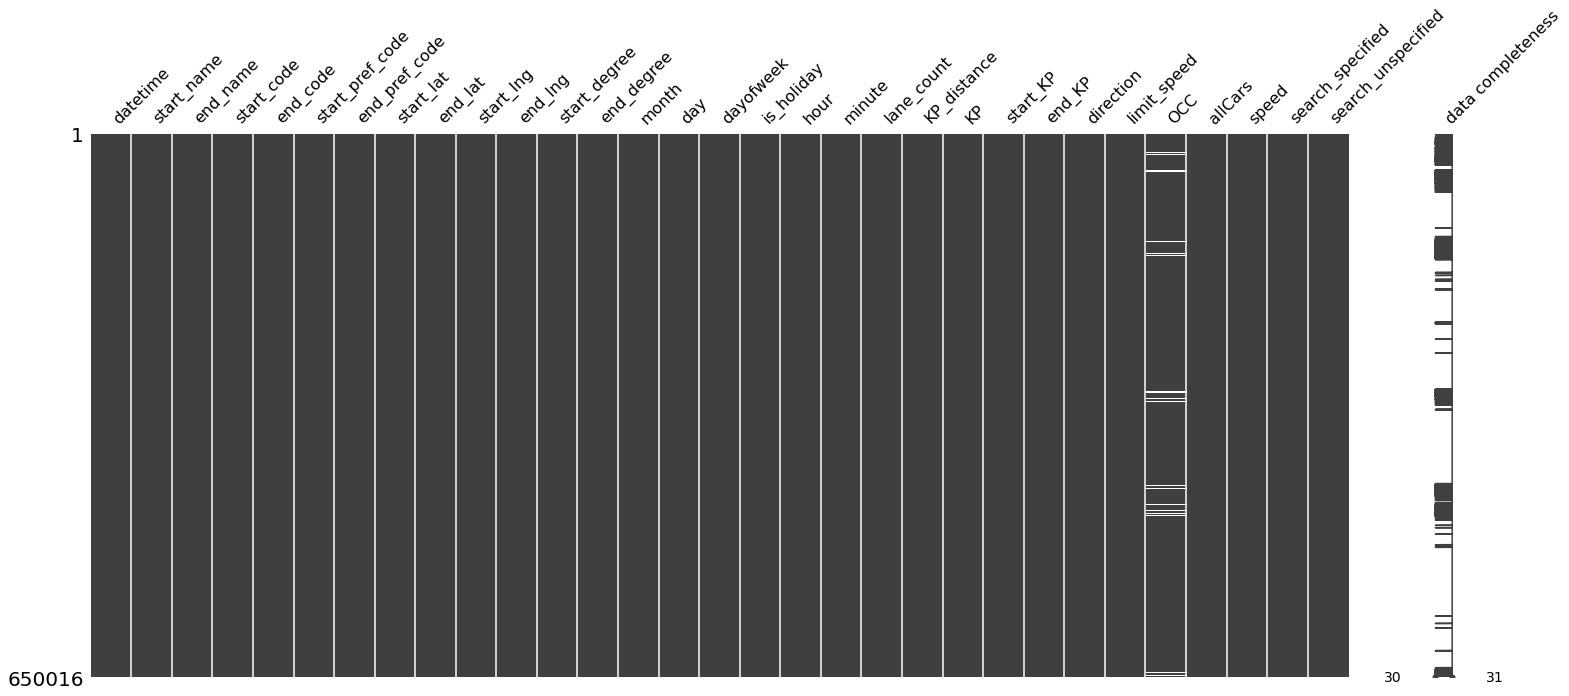

In [50]:
%time msno.matrix(df.to_pandas(), labels=True)
plt.show()

# 最終確認・保存

In [51]:
df = df.sort_values(['start_code', 'end_code', 'KP', 'datetime']).reset_index(drop=True)
df.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed,search_specified,search_unspecified
0,2023-10-01 00:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,2.000000,623.0,89.459936,85,9381.0
1,2023-10-01 01:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,1.333333,428.0,88.256410,23,9381.0
2,2023-10-01 02:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.723697,...,5.47,4.8,10.5,down,100.0,1.000000,331.0,87.548193,19,9381.0


In [52]:
df.tail(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed,search_specified,search_unspecified
650013,2024-03-31 21:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,...,168.082,169.7,160.5,上り,100.0,2.000000,618.0,100.004847,28,3736.0
650014,2024-03-31 22:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,...,168.082,169.7,160.5,上り,100.0,1.833333,475.0,98.338235,30,3736.0
650015,2024-03-31 23:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,...,168.082,169.7,160.5,上り,100.0,1.416667,325.0,96.193252,16,3736.0


CPU times: user 2.23 s, sys: 256 ms, total: 2.48 s
Wall time: 2.21 s


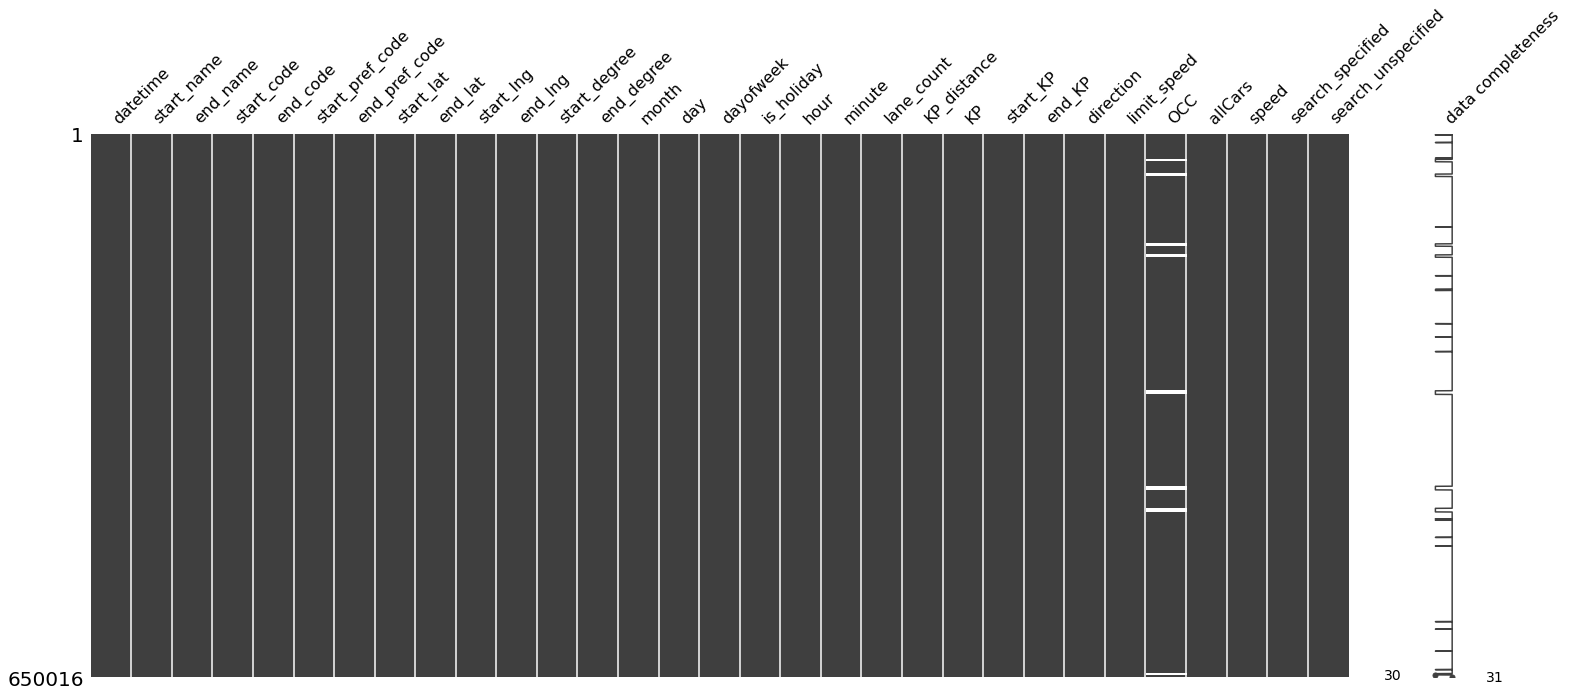

In [53]:
%time msno.matrix(df.to_pandas(), labels=True)
plt.show()

In [54]:
OUTPUT_FILE = f'./traffic/merged_1h_{TARGET_ROAD}_{PERIOD}_2KP.csv'

In [55]:
%time df.to_pandas().to_csv(OUTPUT_FILE, index=False)

CPU times: user 15.4 s, sys: 149 ms, total: 15.5 s
Wall time: 15.5 s


In [56]:
!head -n5 "$OUTPUT_FILE"

datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,month,day,dayofweek,is_holiday,hour,minute,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed,search_specified,search_unspecified
2023-10-01 00:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.72369722222223,139.69075,4.0,4.0,10,1,7,1,0,0,3,5.7,5.47,4.8,10.5,down,100.0,2.0,623.0,89.4599358974359,85,9381.0
2023-10-01 01:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.72369722222223,139.69075,4.0,4.0,10,1,7,1,1,0,3,5.7,5.47,4.8,10.5,down,100.0,1.3333333333333333,428.0,88.25641025641026,23,9381.0
2023-10-01 02:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.72369722222223,139.69075,4.0,4.0,10,1,7,1,2,0,3,5.7,5.47,4.8,10.5,down,100.0,1.0,331.0,87.54819277108433,19,9381.0
2023-10-01 03:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.72369722222223,139.69075,4.0,4.0,10,1,7,1,3,0,3,5.7,5.47,

In [57]:
!tail -n5 "$OUTPUT_FILE"

2024-03-31 19:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,3,31,7,1,19,0,2,9.199999999999989,168.082,169.7,160.5,上り,100.0,2.9166666666666665,887.0,98.76238738738739,66,3736.0
2024-03-31 20:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,3,31,7,1,20,0,2,9.199999999999989,168.082,169.7,160.5,上り,100.0,2.6666666666666665,814.0,99.48466257668711,23,3736.0
2024-03-31 21:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,3,31,7,1,21,0,2,9.199999999999989,168.082,169.7,160.5,上り,100.0,2.0,618.0,100.0048465266559,28,3736.0
2024-03-31 22:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,3,31,7,1,22,0,2,9.199999999999989,168.082,169.7,160.5,上り,100.0,1.8333333333333333,475.0,98.33823529411765,30,3736.0
2024-03-31 23:00:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,3,31,7,1,23,0,2,9.1999999999999

In [58]:
!du -h "$TRAFFIC_DIR"/*

40K	./traffic/Untitled.ipynb
0	./traffic/bak/.ipynb_checkpoints
26G	./traffic/bak
2.7G	./traffic/kannetsu_20210401-20220331_2KP.csv
6.7G	./traffic/kannetsu_20210401-20230930_2KP.csv
7.6G	./traffic/kannetsu_20210401-20240131_2KP.csv
2.7G	./traffic/kannetsu_20220401-20230331_2KP.csv
1.4G	./traffic/kannetsu_20230401-20230930_2KP.csv
915M	./traffic/kannetsu_20231001-20240131_2KP.csv
1.4G	./traffic/kannetsu_20231001-20240331_2KP.csv
722M	./traffic/kannetsu_20240201-20240506_2KP.csv
271M	./traffic/kannetsu_20240401-20240506_2KP.csv
265M	./traffic/merged_1h_kannetsu_20210401-20220331_2KP.csv
659M	./traffic/merged_1h_kannetsu_20210401-20230930_2KP.csv
752M	./traffic/merged_1h_kannetsu_20210401-20240131_2KP.csv
263M	./traffic/merged_1h_kannetsu_20220401-20230331_2KP.csv
132M	./traffic/merged_1h_kannetsu_20230401-20230930_2KP.csv
89M	./traffic/merged_1h_kannetsu_20231001-20240131_2KP.csv
27M	./traffic/merged_1h_kannetsu_20240401-20240506_2KP.csv
286M	./traffic/merged_1h_touhoku_20210401-20220331